In this notebook, we take a look at response-time-related analyses

# Table of Contents
1. [Preparing the data and plots](#preparing)
2. [Response time](#RT)
    * [Correct vs error trials](#RT_correct_error)
    * [CoM vs non-CoM trials](#RT_CoM)
3. [Negative response times](#negative)

<a name="preparing"></a>
# Preparing data and plots
First, we set up visuals and read the data.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import data_reader
import os

data_path = 'C:/Users/azgonnikov/Google Drive/data/CoM_fixed_duration/processed'
figure_path = '../output/figures'
dr = data_reader.DataReader()
choices, dynamics = dr.get_data(data_path, rename_vars=True)

# these two subjects have exceedingly high number of CoMs, which suggest 
# they're not real CoMs but probably just a way of responding
choices = choices[~choices.index.get_level_values(0).isin([216,747])]
dynamics = dynamics[~dynamics.index.get_level_values(0).isin([216,747])]

# here we need to highlight the data by subj_id, and this is currently not possible in seaborn with multi-index dataframes
choices = choices.reset_index()

Let's define a few functions used further to plot initiation times as a function of coherence split by choice and type

In [25]:
import matplotlib.lines as mlines

def plot_var_vs_coherence(choices, var, estimator=np.mean): 
    palette_subj = 'magma_r'
    scale = 1
    subj_order = sorted(choices.subj_id.unique())
    
    plt.figure()
    
    ax = sns.pointplot(data=choices[(choices.is_correct) & (choices.coherence>0)], 
                       x='coherence', y=var, hue='subj_id', 
                       palette=palette_subj, scale=scale, errwidth=0.5, alpha=0.7,
                       join=False, dodge=True, capsize=.2, hue_order=subj_order,
                       estimator=estimator)
    
    ax = sns.pointplot(data=choices[(~choices.is_correct) & (choices.coherence>0)], 
                       x='coherence', y=var, hue='subj_id', 
                       palette=palette_subj, linestyles=np.repeat(['--'], len(choices.subj_id.unique())), 
                       markers=np.repeat(['x'], len(choices.subj_id.unique())), scale=scale,
                       errwidth=0.5, dodge=True, capsize=.2, join=False, 
                       hue_order=subj_order, estimator=estimator, ax=ax)

    ax = sns.pointplot(data=choices[(choices.coherence>0) & (~choices.is_correct)], 
                       x='coherence', y=var, linestyles=['--'], color='grey',
                       markers=['x'], scale=scale, errwidth=0.5, estimator=estimator, ax=ax)
    
    ax = sns.pointplot(data=choices[(choices.coherence>0) & (choices.is_correct)],
                       x='coherence', y=var, linestyles=['-'], color='grey', 
                       scale=scale, errwidth=0.5, estimator=estimator, ax=ax)


#     ax.set_ylim([0, 1.2])      
    ax.set_xlabel('Coherence')
    ax.set_ylabel(var)
    
    ax.legend_.remove()
    correct_line = mlines.Line2D([], [], color='grey', marker='o', lw=3.0, label='Correct')
    error_line = mlines.Line2D([], [], color='grey', marker='x', ls='--', lw=3.0, label='Error')
    plt.legend(handles=[correct_line, error_line], frameon=False)
    
    sns.despine(ax=ax, trim=True, offset=5)
    
    plt.tight_layout()
#     plt.savefig(('figures/%s_vs_coherence_ind_%s' % 
#                  (var.replace('(', '').replace(')', ''), exp)).replace(' ', '_'), bbox_inches='tight')
    
def plot_var_grid_individual(choices, var, col, hue, hue_order, col_order, markers, estimator=np.mean):
    ax = sns.catplot(kind='point', data=choices[choices.coherence>0], x='coherence', y=var, 
                        col=col, row='subj_id', markers = markers, hue=hue, hue_order=hue_order,
                        capsize=.2, errwidth=0.5, estimator=estimator)
    ax.set_ylabels('Response time (z)')
    
    plt.subplots_adjust(top=0.9)    
    
#     plt.savefig(('../../figures_output/%s_vs_coherence_grid_by_%s_ind' % (var, hue)).replace(' ', '_'))

def plot_var_grid(choices, var, col, hue, hue_order, col_order, markers, estimator=np.mean, title=True, xlabels=True):
    fig = sns.catplot(kind='point', data=choices[choices.coherence>0], x='coherence', y=var, col=col, 
                         linestyles=['-','--'], markers = markers, hue=hue, hue_order=hue_order, col_order=col_order,
                         capsize=.2, errwidth=0.5, ylim=(-1, 1), estimator=estimator, legend=False)
    fig.set_xticklabels(rotation=30)
    fig.set(ylim=(-2.5, 2.5))
    fig.set_titles('')
    plt.subplots_adjust(top=0.8)
    fig.despine(trim=True, offset=10)
    if not xlabels:
        fig.set_xlabels('')
    
    if title:        
        fig.set_titles('{col_name}')
        
    plt.legend(loc='lower left', frameon=False)
#     plt.savefig(('figures/%s_vs_coherence_grid_by_%s_%s' % 
#                  (var.replace('(', '').replace(')', ''), hue, exp)).replace(' ', '_'), bbox_inches='tight')

<a name="RT"></a>
# Response time

First, we plot IT distributions for both experiments. Note that IT for both mouse and eye can be negative, as premature responses during stimulus presentations are factored in during pre-processing.

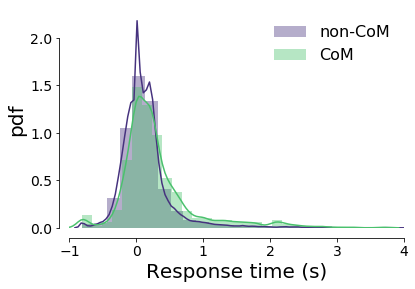

In [14]:
sns.set_palette('viridis')
ax = sns.distplot(choices[~choices.is_com].RT, bins=30, label='non-CoM', color='C0')
sns.distplot(choices[choices.is_com].RT, bins=30, ax=ax, label='CoM', color='C4')
ax.set_ylabel('pdf')
ax.set_xlim(-1, 4)
ax.set_xlabel('Response time (s)')
sns.despine(ax=ax, trim=True, offset=10)

plt.legend(frameon=False)
plt.savefig(os.path.join(figure_path, 'RT.png') , bbox_inches='tight')

Now, let's look at mouse initation times for each coherence level

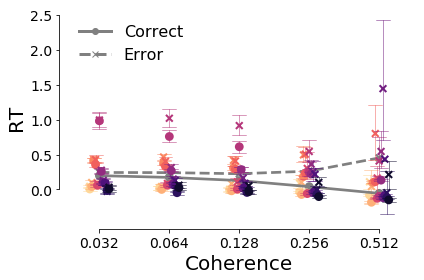

In [15]:
plot_var_vs_coherence(choices, var='RT')

Pretty much what we expect: RT decreases with coherence for correct trials, and remains more-less constant or even increases for error trials __(the 'V-pattern')__.

Z-scored RT highlights the same pattern:

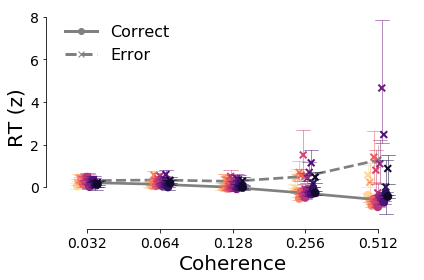

In [16]:
plot_var_vs_coherence(choices, var='RT (z)')

These plotting functions are used for the mouse and eye IT data analyses below

<a name="mouse_IT_correct_error"></a>
## Initiation time in correct vs error trials

Taking into account individual differences in initiation times, it is useful to account for those when looking into initiation times for CoM and non-CoM trials. Here we have to look at z-scored initiation times though, to get general patterns.

After we accounted for magnitude of within-individual initiation times, we can see how relative magnitude of initiation time changes with coherence in non-CoM and CoM trials:

In [17]:
sns.set_palette('tab10')

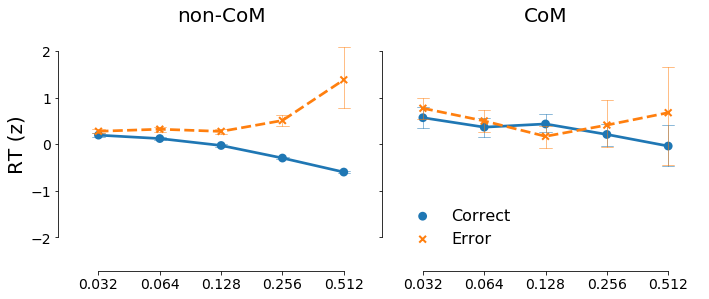

In [18]:
plot_var_grid(choices, var='RT (z)', col='type', hue='choice', 
              hue_order=['Correct', 'Error'],  col_order=['non-CoM', 'CoM'], markers=['o', 'x'], xlabels=False)

Surprisingly, in CoM trials participants exhibit identical relative initiation times in correct and error trials! This was observed in both experiments. In individual patterns it's harder to see this though.

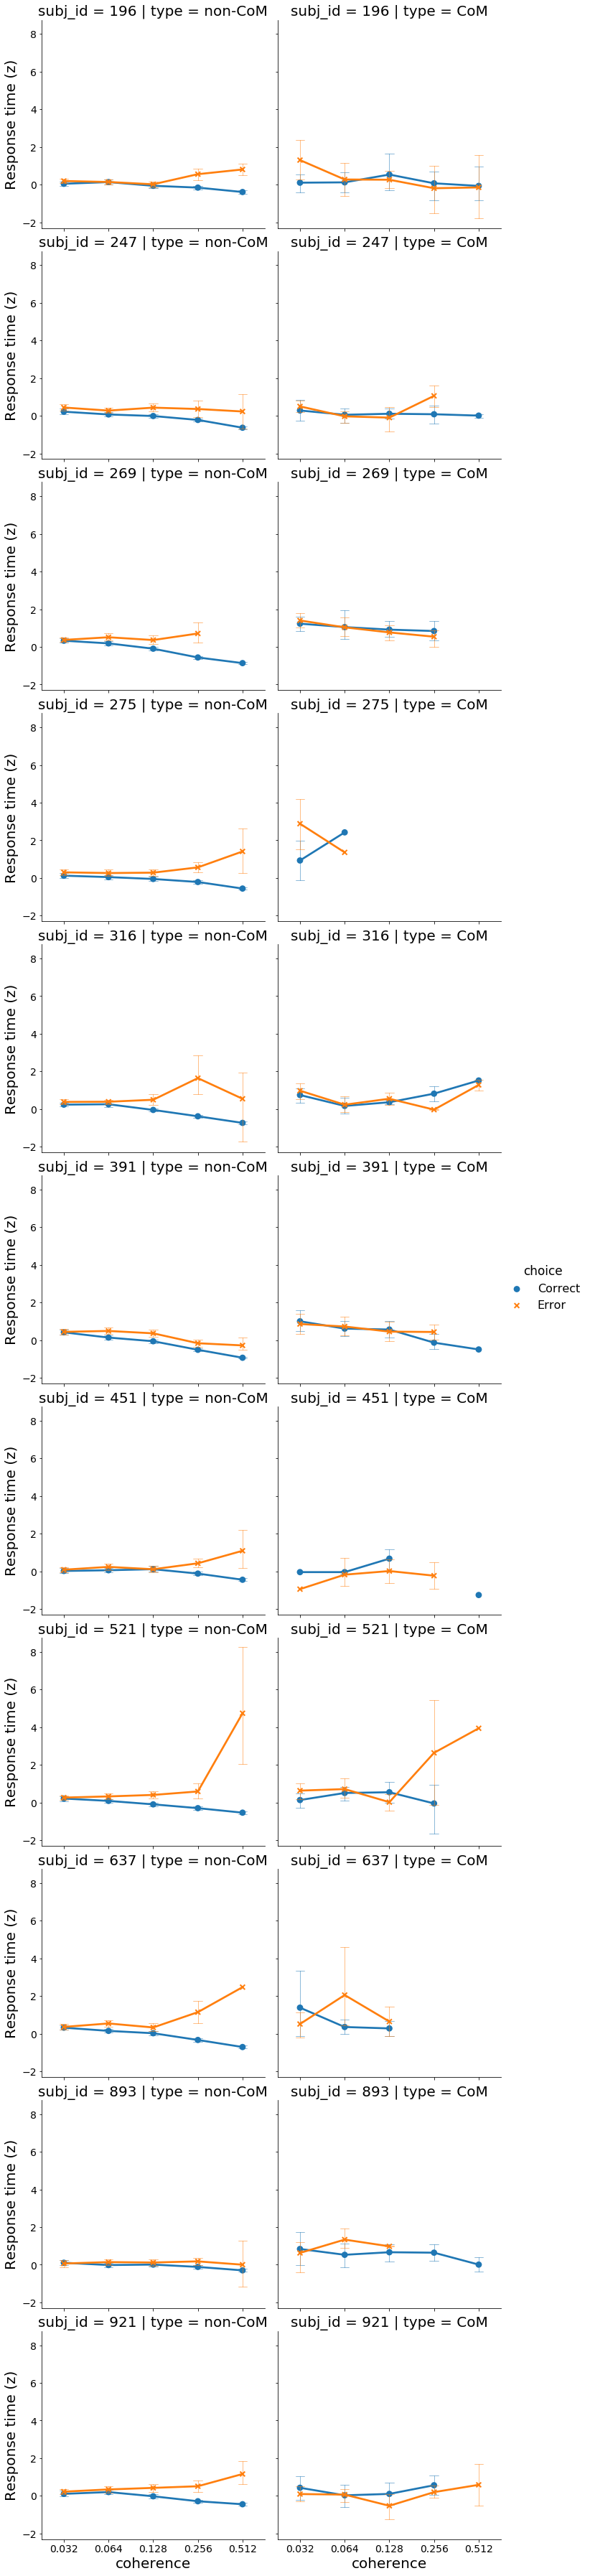

In [26]:
plot_var_grid_individual(choices, var='RT (z)', col='type', hue='choice', 
                        hue_order=['Correct', 'Error'], col_order=['non-CoM', 'CoM'], markers=['o', 'x'])

<a name="mouse_IT_CoM"></a>
## Initiation time in CoM vs non-CoM trials

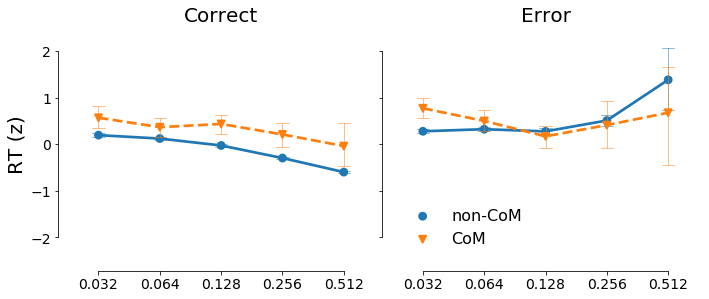

In [27]:
plot_var_grid(choices, var='RT (z)', col='choice', hue='type', 
              hue_order=['non-CoM', 'CoM'], col_order=['Correct', 'Error'], markers=['o', 'v'], xlabels=False)

Correct initation times are reliably longer than those in error trials

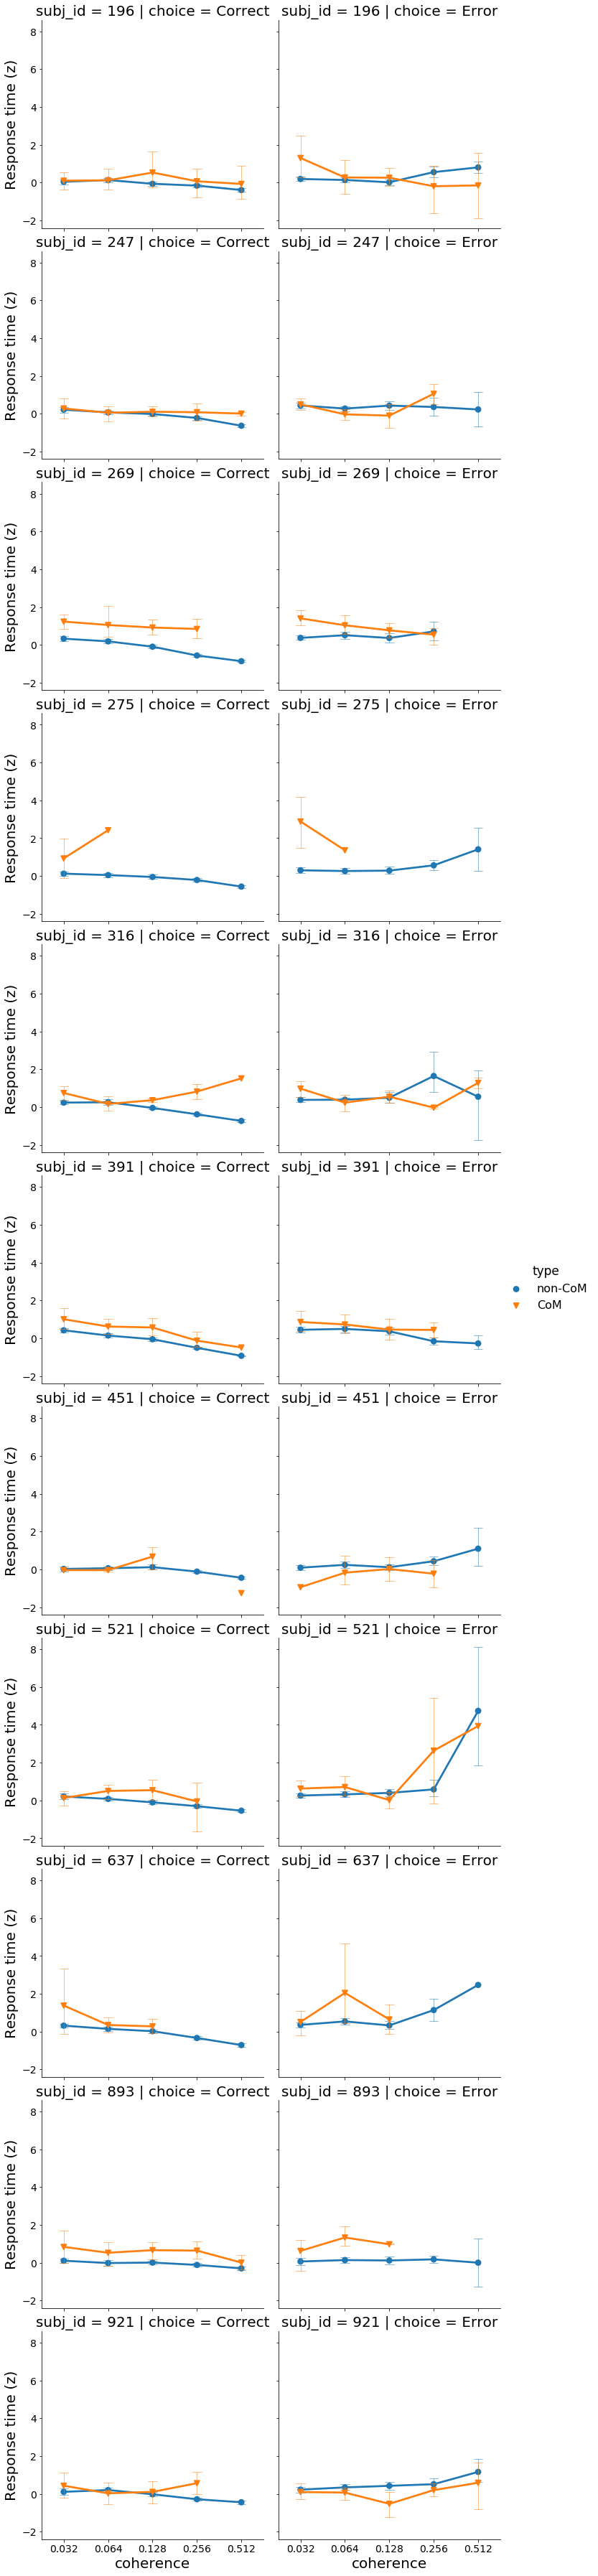

In [28]:
plot_var_grid_individual(choices, var='RT (z)', col='choice', hue='type', 
              hue_order=['non-CoM', 'CoM'], col_order=['Correct', 'Error'], markers=['o', 'v'])

<a name="negative"></a>
# Negative initiation times

Premature responses were observed in 30% of the trials

In [29]:
def print_neg_RT_proportion(choices):
    print('N: %i' % (len(choices[(choices['RT']<0)])))
    print('rate: %.3f' % (len(choices[(choices['RT']<0)])/len(choices)))

print_neg_RT_proportion(choices)

N: 7938
rate: 0.298


However, there are just 20% of CoM trials had premature responses

In [30]:
print_neg_RT_proportion(choices[choices.is_com])

N: 187
rate: 0.196


Let's see how the probability of premature response changes with coherence for CoM and non-CoM trials

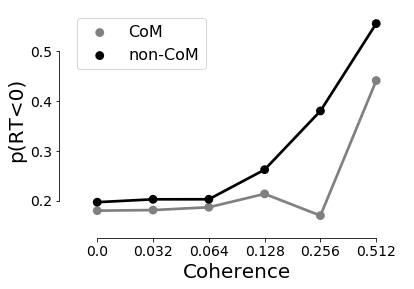

In [31]:
def get_p_neg_RT(choices):
    return (choices.groupby(by=['coherence', 'type']).apply(lambda c: (len(c[c['RT']<0]))/len(c)).rename('p(RT<0)').reset_index())
    
fig = plt.figure()
ax = fig.add_subplot(111)
data=get_p_neg_RT(choices)
# ax.plot(data[~data.is_com])
sns.pointplot(data=get_p_neg_RT(choices), x='coherence', y='p(RT<0)', ci=None, ax=ax, palette=['grey', 'black'], hue='type')
ax.set_xlabel('Coherence')
ax.get_legend().set_title('')
sns.despine(ax=ax, trim=True, offset=10)

plt.savefig(os.path.join(figure_path, 'p_neg_RT.png') , bbox_inches='tight')

# Time of CoM

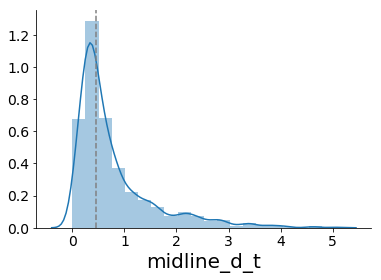

In [32]:
ax = sns.distplot(choices[choices.is_com].midline_d_t, bins=20)
ax.axvline(0.45, color='grey', ls='--')

In [33]:
print(len(choices[choices.is_com & (choices.midline_d_t>0.45)])/len(choices[choices.is_com]))

0.5555555555555556


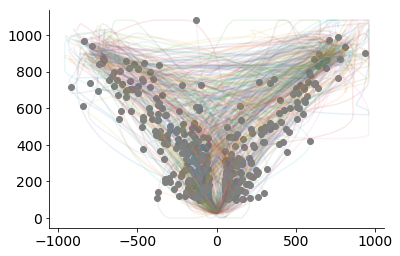

In [36]:
# traj = dynamics.loc[random.choice(choices[choices.is_com & (choices.midline_d_t<0.45)].set_index(dynamics.index.names).index)]
# plt.plot(traj.mouse_x, traj.mouse_y)
choices_ind = choices.set_index(dynamics.index.names)
for name, traj in dynamics.loc[choices_ind[choices_ind.is_com & 
                                           (choices_ind.midline_d_t<0.45)].index].groupby(dynamics.index.names):
    plt.plot(traj.mouse_x, traj.mouse_y, alpha=0.1)
    com_idx = int(choices_ind.loc[name].idx_midline_d)  
    plt.plot(traj.mouse_x[com_idx], traj.mouse_y[com_idx], color='grey', marker='o')